In [1]:
#Allows relative imports
import os
import sys
import pandas as pd 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
#imports 
from src.preprocessing import *
from src.models import *
from src.train_eval_helpers import *
from src.plots import *
import torch
import torch.nn as nn
import torch.nn.functional as F
%load_ext autoreload
%autoreload 2
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']= 300
import seaborn as sns
sns.set_style('darkgrid')

#checking gpu status
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using : {}".format(device))
else:
    device = torch.device('cpu')
    print("Using : {}".format(device))

RANGE = range(12,17)
TRAINDIR = '../TrainingData/'

Using : cuda


In [23]:
AAs= ['A','R','N','D','B','C','E','Q','Z','G',
'H','I','L','K','M','F','P','S','T','W','Y','V']
def filter_df(df, v = False):
    df = df.dropna(subset=['amino_acid'])\
           .query('amino_acid.str.len()>=12 & amino_acid.str.len()<=16')\
           .query("amino_acid.str.startswith('C') & amino_acid.str.endswith('F')")\
           .query('not amino_acid.str.contains("\*")')\
           .query('not amino_acid.str.contains("\~")')
    df['len'] = df.amino_acid.str.len()
    df.drop_duplicates(subset='amino_acid',inplace=True)
    return df

#manual 1hot encode lol
AA_KEYS = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L',
           'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
char_to_int = dict((c,i) for i,c in enumerate(AA_KEYS))
int_to_char = dict((i,c) for i,c in enumerate(AA_KEYS))

def onehot_aa(seq):
    int_encoded = [char_to_int[char] for char in seq]
    onehot_encoded = list()
    for value in int_encoded:
        letter = [0 for _ in range(len(AA_KEYS))]
        letter[value] = 1
        onehot_encoded.append(letter)
    return np.array(onehot_encoded).flatten()

def aaidx_reshaped(seq, device=None, scaling='minmax'):
    out = aaindex_encoding(seq, device, scaling)
    return out.reshape(-1,).numpy()

def atchley_reshaped(seq, device=None, scaling='minmax'):
    out = atchley_encoding(seq,device,scaling)
    return out.reshape(-1,).numpy()

from sklearn.decomposition import PCA 

def get_reduc(df, col, n=3, crop = False):#, top=100):
    #Getting onehot features for PCA
    pca = PCA(n_components=n)
    tmp = df.copy()
    X = np.array([x for x in df[col]])
    #print(type(X), X.shape)
    comp = pca.fit_transform(X)
    #print("Explained var ratios :",pca.explained_variance_ratio_)
    #print("Explained var : ",pca.explained_variance_)
    for i in range(n):
        tmp['PCA'+str(i+1)]=comp[:,i]
    var_ratio = pca.explained_variance_ratio_.tolist()
    var_ratio = ['{:g}'.format(float('{:.3g}'.format(i))) for i in var_ratio]
    tmp['explained_var'] = [var_ratio for _ in range(len(tmp))]
    return tmp

def get_pca(df, col,n=3):
    df = df.copy()
    #df[col] = df['amino_acid'].apply(onehot_aa)
    output = get_reduc(df,n)
    return output


def plot_pca(df, hue,name):
    ll = df.len.unique().item()
    vars_=[z for z in df.columns if z.startswith('PCA')]
    g = sns.PairGrid(df, x_vars = vars_,
                     y_vars = vars_,
                     diag_sharey=False, hue=hue)
    g.fig.suptitle('{} TCR, PCA with {} components for L = {}'\
                   '\nExplained variance ratios : {}'.format(name,len(vars_),ll, 
                                                                 df.explained_var.values[0]), fontweight='bold')
    g.fig.subplots_adjust(top=0.92)
    g.map_lower(sns.scatterplot, style = df['label'],
                markers=['X','P'],#,'P','P'],
                sizes = [0.2,0.2,0.2,0.1], alpha=0.75)#,0.75,0.75,0.5])
    g.map_upper(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    g.add_legend()
    plt.savefig('{}_tcr_PCA_{}_comp_L{}.jpg'.format(name, len(vars_),ll), dpi=300)
    
sns.set_palette("husl", n_colors=4)

In [3]:
CUR = '../training_data_new/training_data_curated/'
#Rereading the files (19,02.21)
tumor_test = filter_df(pd.read_csv('../TrainingData/TumorCDR3_test.txt', header=None).rename(columns={0:'amino_acid'}))
tumor_train = filter_df(pd.read_csv('../TrainingData/TumorCDR3.txt', header=None).rename(columns={0:'amino_acid'}))
normal_train = filter_df(pd.read_csv('../TrainingData/NormalCDR3.txt',header=None).rename(columns={0:'amino_acid'}))
mcc_tumor = pd.read_csv(CUR+'mcc_curated_tumor_or_tils.csv')#.rename(columns={'amino_acid':'aa'})
naive_df = pd.read_csv(CUR+'dataset1_MCC_naive/naive_test.csv')#.rename(columns={'amino_acid':'aa'})

tumor_train['label']='og_tumor'
normal_train['label']='og_normal'
mcc_tumor['label']='mcc'
naive_df['label']='naive'

total = pd.concat([tumor_train[['amino_acid','len','label']], 
                   normal_train[['amino_acid','len','label']], 
                   mcc_tumor[['amino_acid','len','label']], 
                   naive_df[['amino_acid','len','label']]], ignore_index=True)

total['aa_idx'] = total['amino_acid'].apply(aaidx_reshaped)
total['atchley'] = total['amino_acid'].apply(atchley_reshaped)

In [29]:
def plot_pca(df, hue, name):
    ll = df.len.unique().item()
    vars_=[z for z in df.columns if z.startswith('PCA')]
    g = sns.PairGrid(df, x_vars = vars_,
                     y_vars = vars_,
                     diag_sharey=False, hue=hue)
    g.fig.suptitle('{} TCR, PCA with {} components for L = {}'\
                   '\nExplained variance ratios : {}'.format(name,len(vars_),ll, 
                                                                 df.explained_var.values[0]), fontweight='bold')
    g.fig.subplots_adjust(top=0.92)
    g.map_lower(sns.scatterplot, style = df['label'],
                markers=['X','P'],#,'P','P'],
                sizes = [0.2,0.2,0.2,0.1], alpha=0.75)#,0.75,0.75,0.5])
    g.map_upper(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    g.add_legend()
    plt.savefig('./output/og_comp/{}_tcr_PCA_{}comp_L{}.jpg'.format(name, len(vars_),ll), dpi=300)
    
sns.set_palette('husl',n_colors=2)

for col in ['aa_idx','atchley']:
    for ll in range(12,17):
        for n in [3]:
            df = get_reduc(total.query('len==@ll & label != "mcc" & label != "naive"'),
                           col, n)
            df.sort_values('label',ascending=False)
            plot_pca(df, hue='label',name=('og_{}_L{}').format(col,ll))
            plt.close()

### Redoing PCA with ommited starting/end 4 amino acids



In [71]:
def plot_pca(df, hue, name, **kwargs):
    ll = df.len.unique().item()
    vars_=[z for z in df.columns if z.startswith('PCA')]
    g = sns.PairGrid(df, x_vars = vars_,
                     y_vars = vars_,
                     diag_sharey=False, hue=hue)
    g.fig.suptitle('{} TCR, PCA with {} components for L = {}'\
                   '\nExplained variance ratios : {}'.format(name,len(vars_),ll, 
                                                                 df.explained_var.values[0]), fontweight='bold')
    g.fig.subplots_adjust(top=0.92)
    g.map_lower(sns.scatterplot, style = df['label'],
                **kwargs,
                sizes = [0.2,0.2,0.2,0.1], alpha=0.75)#,0.75,0.75,0.5])
    g.map_upper(sns.kdeplot)
    g.map_diag(sns.kdeplot)
    g.add_legend()
    plt.savefig('./output/cropped/cropped_{}_tcr_PCA_{}comp_L{}.jpg'.format(name, len(vars_),ll), dpi=300)
    
sns.set_palette('husl',n_colors=2)

def get_reduc_crop(df, col, n=3, crop = True):#, top=100):
    #Getting onehot features for PCA
    pca = PCA(n_components=n)
    tmp = df.copy()
    X = np.array([x for x in df[col]])
    if crop ==True and col == 'atchley':
        X = X[:, 20:-20]
    elif crop == True and col == 'aa_idx':
        X = X[:, 60:-60]
    #print(type(X), X.shape)
    comp = pca.fit_transform(X)
    #print("Explained var ratios :",pca.explained_variance_ratio_)
    #print("Explained var : ",pca.explained_variance_)
    for i in range(n):
        tmp['PCA'+str(i+1)]=comp[:,i]
    var_ratio = pca.explained_variance_ratio_.tolist()
    var_ratio = ['{:g}'.format(float('{:.3g}'.format(i))) for i in var_ratio]
    tmp['explained_var'] = [var_ratio for _ in range(len(tmp))]
    return tmp

for col in ['aa_idx','atchley']:
    for ll in range(12,17):
        n=3
        df = get_reduc_crop(total.query('len==@ll & label != "mcc" & label != "naive"'),
                       col, n)
        df.sort_values('label',ascending=False)
        plot_pca(df, hue='label',name=('og_{}_L{}').format(col,ll),  markers=['X','P'])
        plt.close()
        
        df2 = get_reduc_crop(total.query('len==@ll'), col, n)
        df2.sort_values('label',ascending=False)
        plot_pca(df2, hue='label',name=('total_{}_L{}').format(col,ll) , markers=['X','X','P','P'])
        plt.close()

### DISTANCES/similarity


In [4]:
def hamming_distance(string1, string2): 
    # Start with a distance of zero, and count up
    distance = 0
    # Loop over the indices of the string
    L = len(string1)
    for i in range(L):
        # Add 1 to the distance if these two characters are not equal
        if string1[i] != string2[i]:
            distance += 1
    # Return the final count of differences
    return distance

def hamming_df(df):
    hamms = []
    indices = df.index
    for index in indices:  
        diff = df.index.difference([index])
        row = df.loc[index,'amino_acid']
        for other in df.loc[diff,'amino_acid']:
            hamms.append(hamming_distance(row,other))
    return pd.DataFrame(data=hamms,columns=['hamm_dist'])

def get_ham(df, *labels):
    hamming_tot = pd.DataFrame()
    for lab in labels:
        for len_ in range(12,17):
            tmp = hamming_df(df.query('label==@lab & len==@len_').sample(1477))
            tmp['label'] = lab
            tmp['len'] = len_
            hamming_tot = hamming_tot.append(tmp, ignore_index=True)
    return hamming_tot

In [49]:
#To crop first/last 4 aa for atchley 
np.array([x for x in total.query('label=="og_normal" & len ==14')['atchley'].values])[:, 20:-20].shape

(12193, 30)

In [53]:
#To crop first/last 4 aa for aa_idx
np.array([x for x in total.query('label=="og_normal" & len ==12')['aa_idx'].values])[:, 60:-60].shape

(4473, 60)

In [54]:
from sklearn.metrics.pairwise import cosine_similarity as cs

def get_cos(df, col, *labels, crop=False):
    total = pd.DataFrame()
    for lab in labels: 
        #print("\n########## lab:", lab)
        for len_ in range(12,17):
           # print("########len :", len_)
            feats = np.array([x for x in df.query('label==@lab & len==@len_').sample(1477)[col].values])
            if crop ==True and col == 'atchley':
                feats = feats[:, 20:-20]
            elif crop == True and col == 'aa_idx':
                feats = feats[:, 60:-60]
            scores = cs(feats,feats).reshape(-1,1)
            tmp = pd.DataFrame(data=scores, columns=['similarity'])
            tmp['label'] = lab
            tmp['len'] = len_
            total = total.append(tmp.query('not similarity >=1'), ignore_index=True)
    return total

sns.set_palette('BuPu',n_colors=2)
def plot_cos_dist(df, name):# n1, n2):
    f,a = plt.subplots(2,3,figsize=(25,14.5))
    ax = a.ravel()
    RANGE=range(12,17)
    for idx, len_ in enumerate(RANGE):
        tmp = df.query('len==@len_')
        sns.histplot(data=tmp, x='similarity', ax = ax[idx],
                     stat = 'density',
                     discrete=False, hue='label', kde=True)
        #a = tmp.query('label==@n1')['similarity'].values
        #b = tmp.query('label==@n2')['similarity'].values
        #_, p = mwu(a,b)
        ax[idx].set_title('Cosine similarity distribution for L = {}'.format(RANGE[idx]))#\
                            #'\nMann-Whitney U test p-value ={:.4e}'.format(RANGE[idx],p))
    f.suptitle('Cosine similarity using {}'.format(name), fontsize = 18, fontweight='bold')
    f.subplots_adjust(top=.95)
    f.tight_layout(rect=[0, 0, 1, 0.99])
    f.delaxes(ax[-1])
    f.savefig('cos_sim_comparison_'+name+'.jpg', dpi=300)

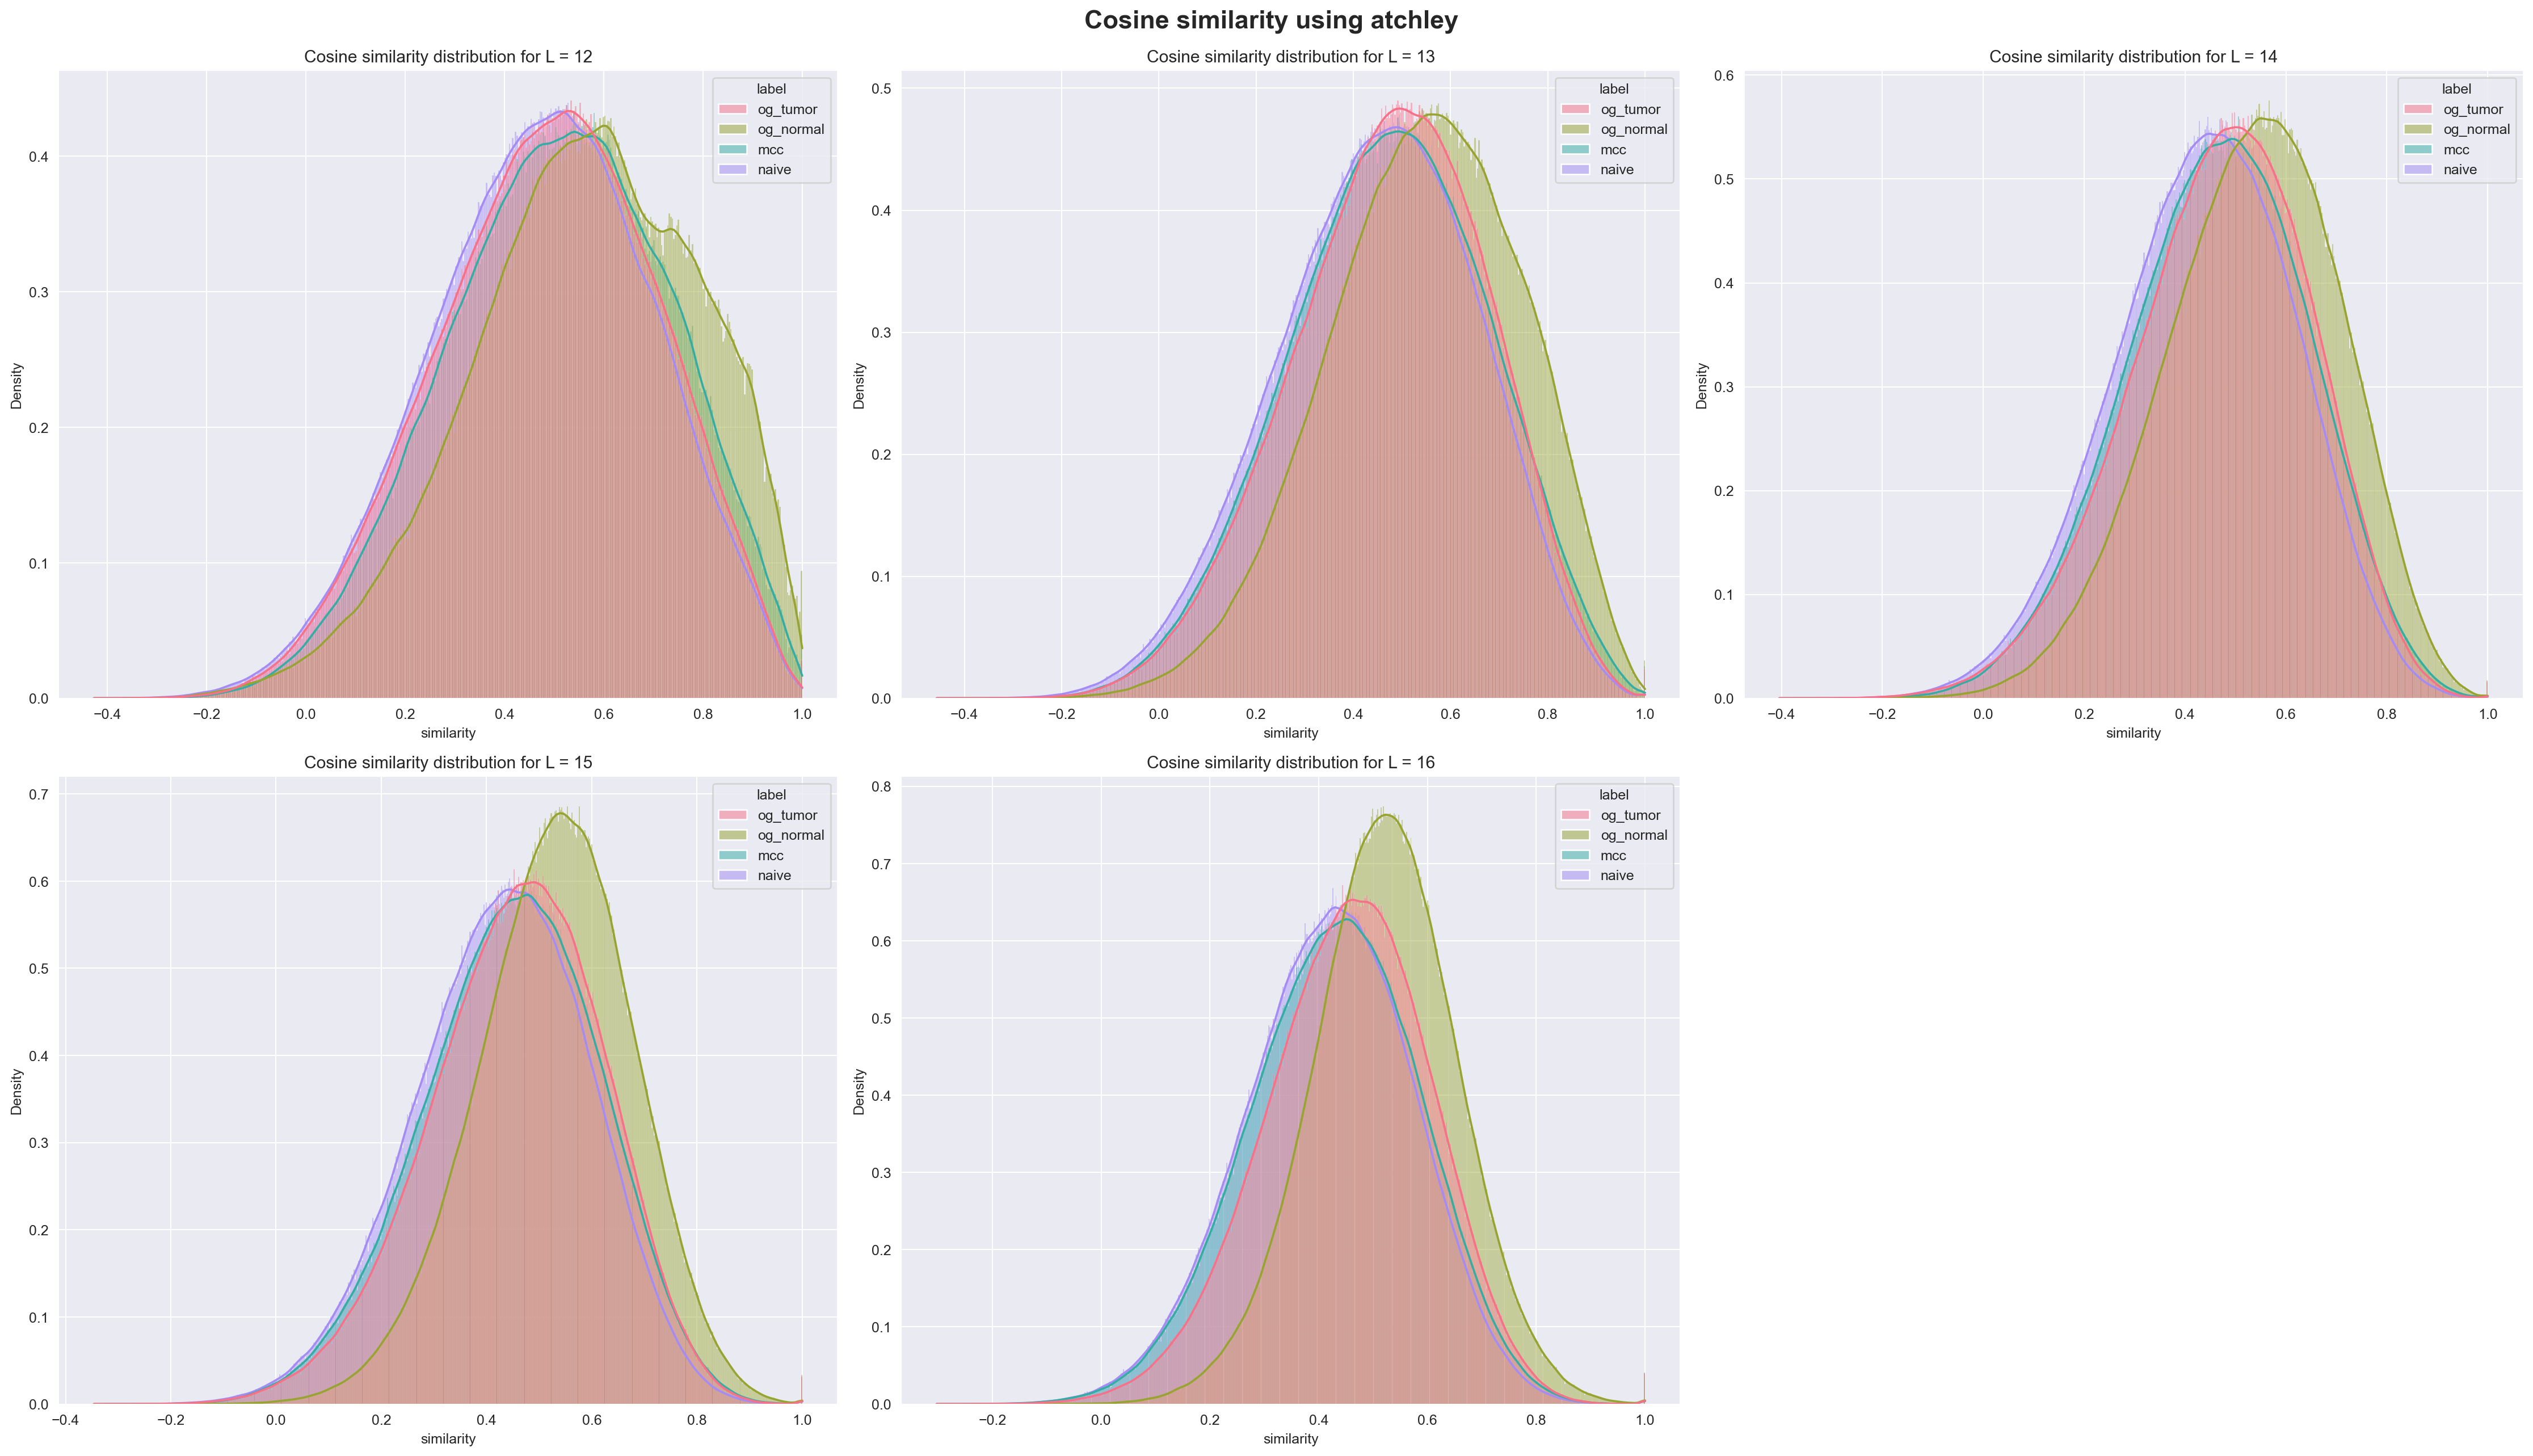

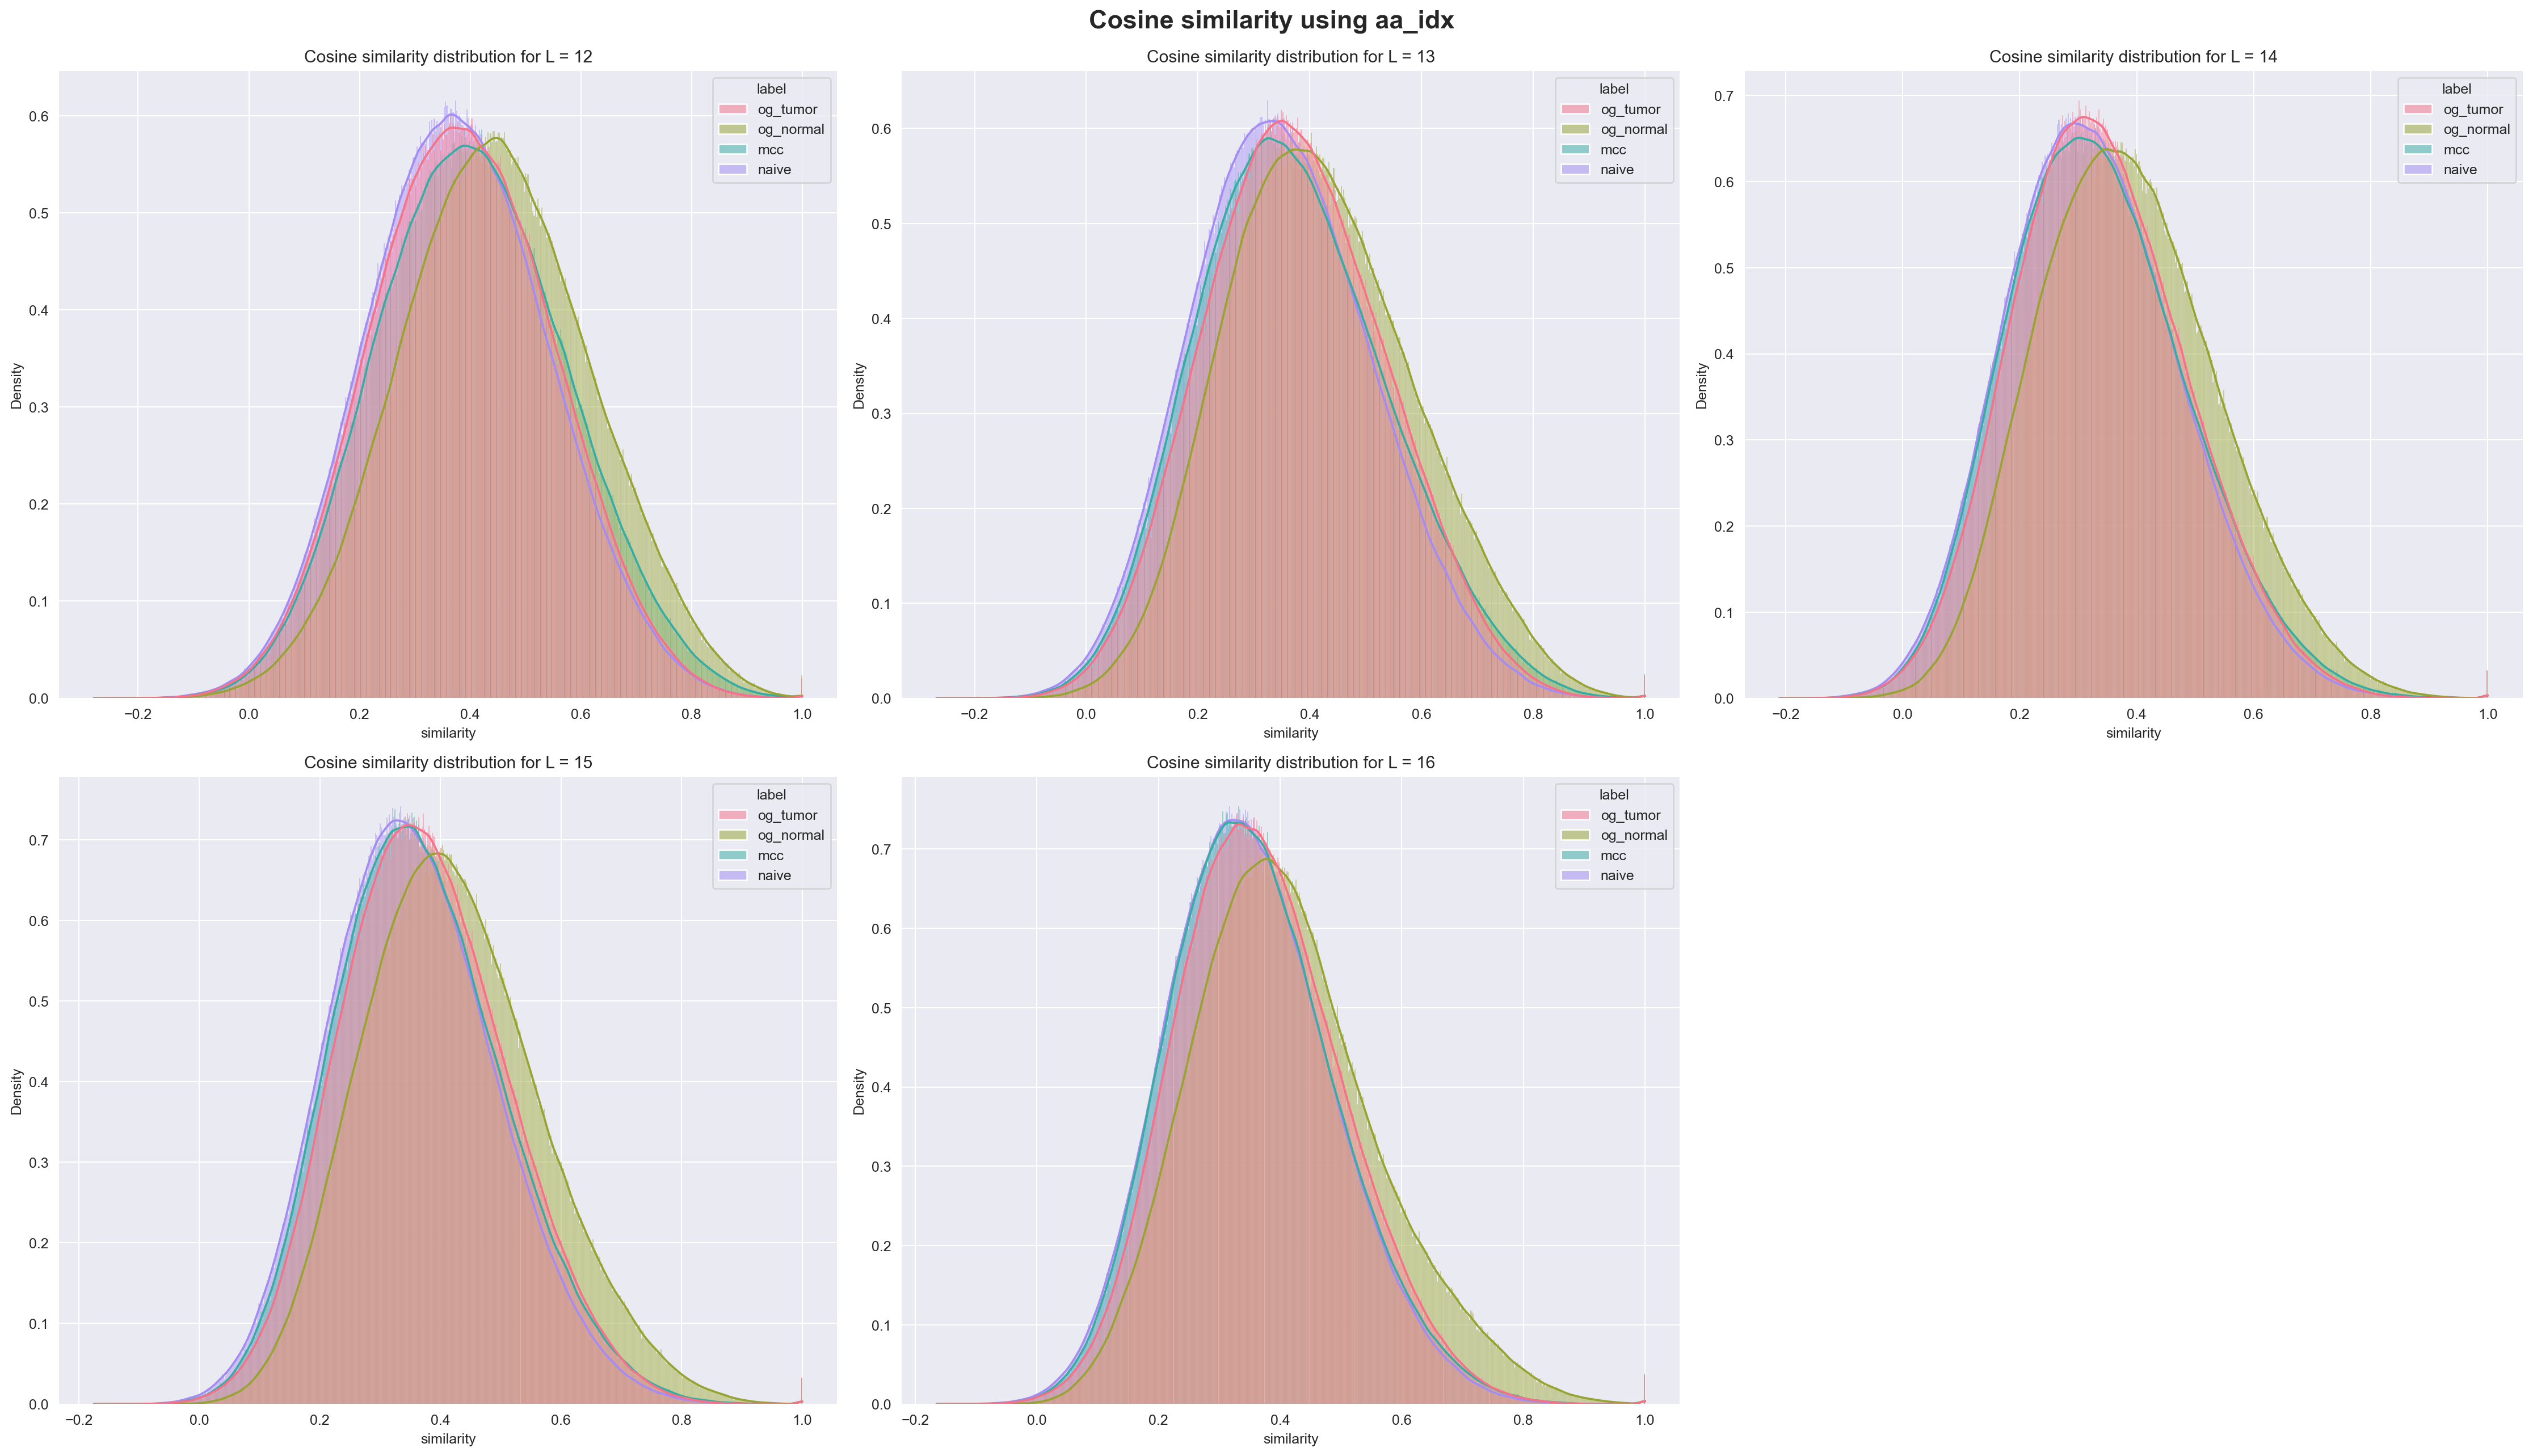

In [56]:
#checking cropped version
sns.set_palette('BuPu',n_colors=2)
atchley_sim = get_cos(total, 'atchley','og_tumor', "og_normal",'mcc', "naive", crop=True)
plot_cos_dist(atchley_sim, 'atchley')#, 'og_tumor','mcc')

aaidx_sim = get_cos(total, 'aa_idx', 'og_tumor', "og_normal", 'mcc', "naive", crop=True)
plot_cos_dist(aaidx_sim,'aa_idx')

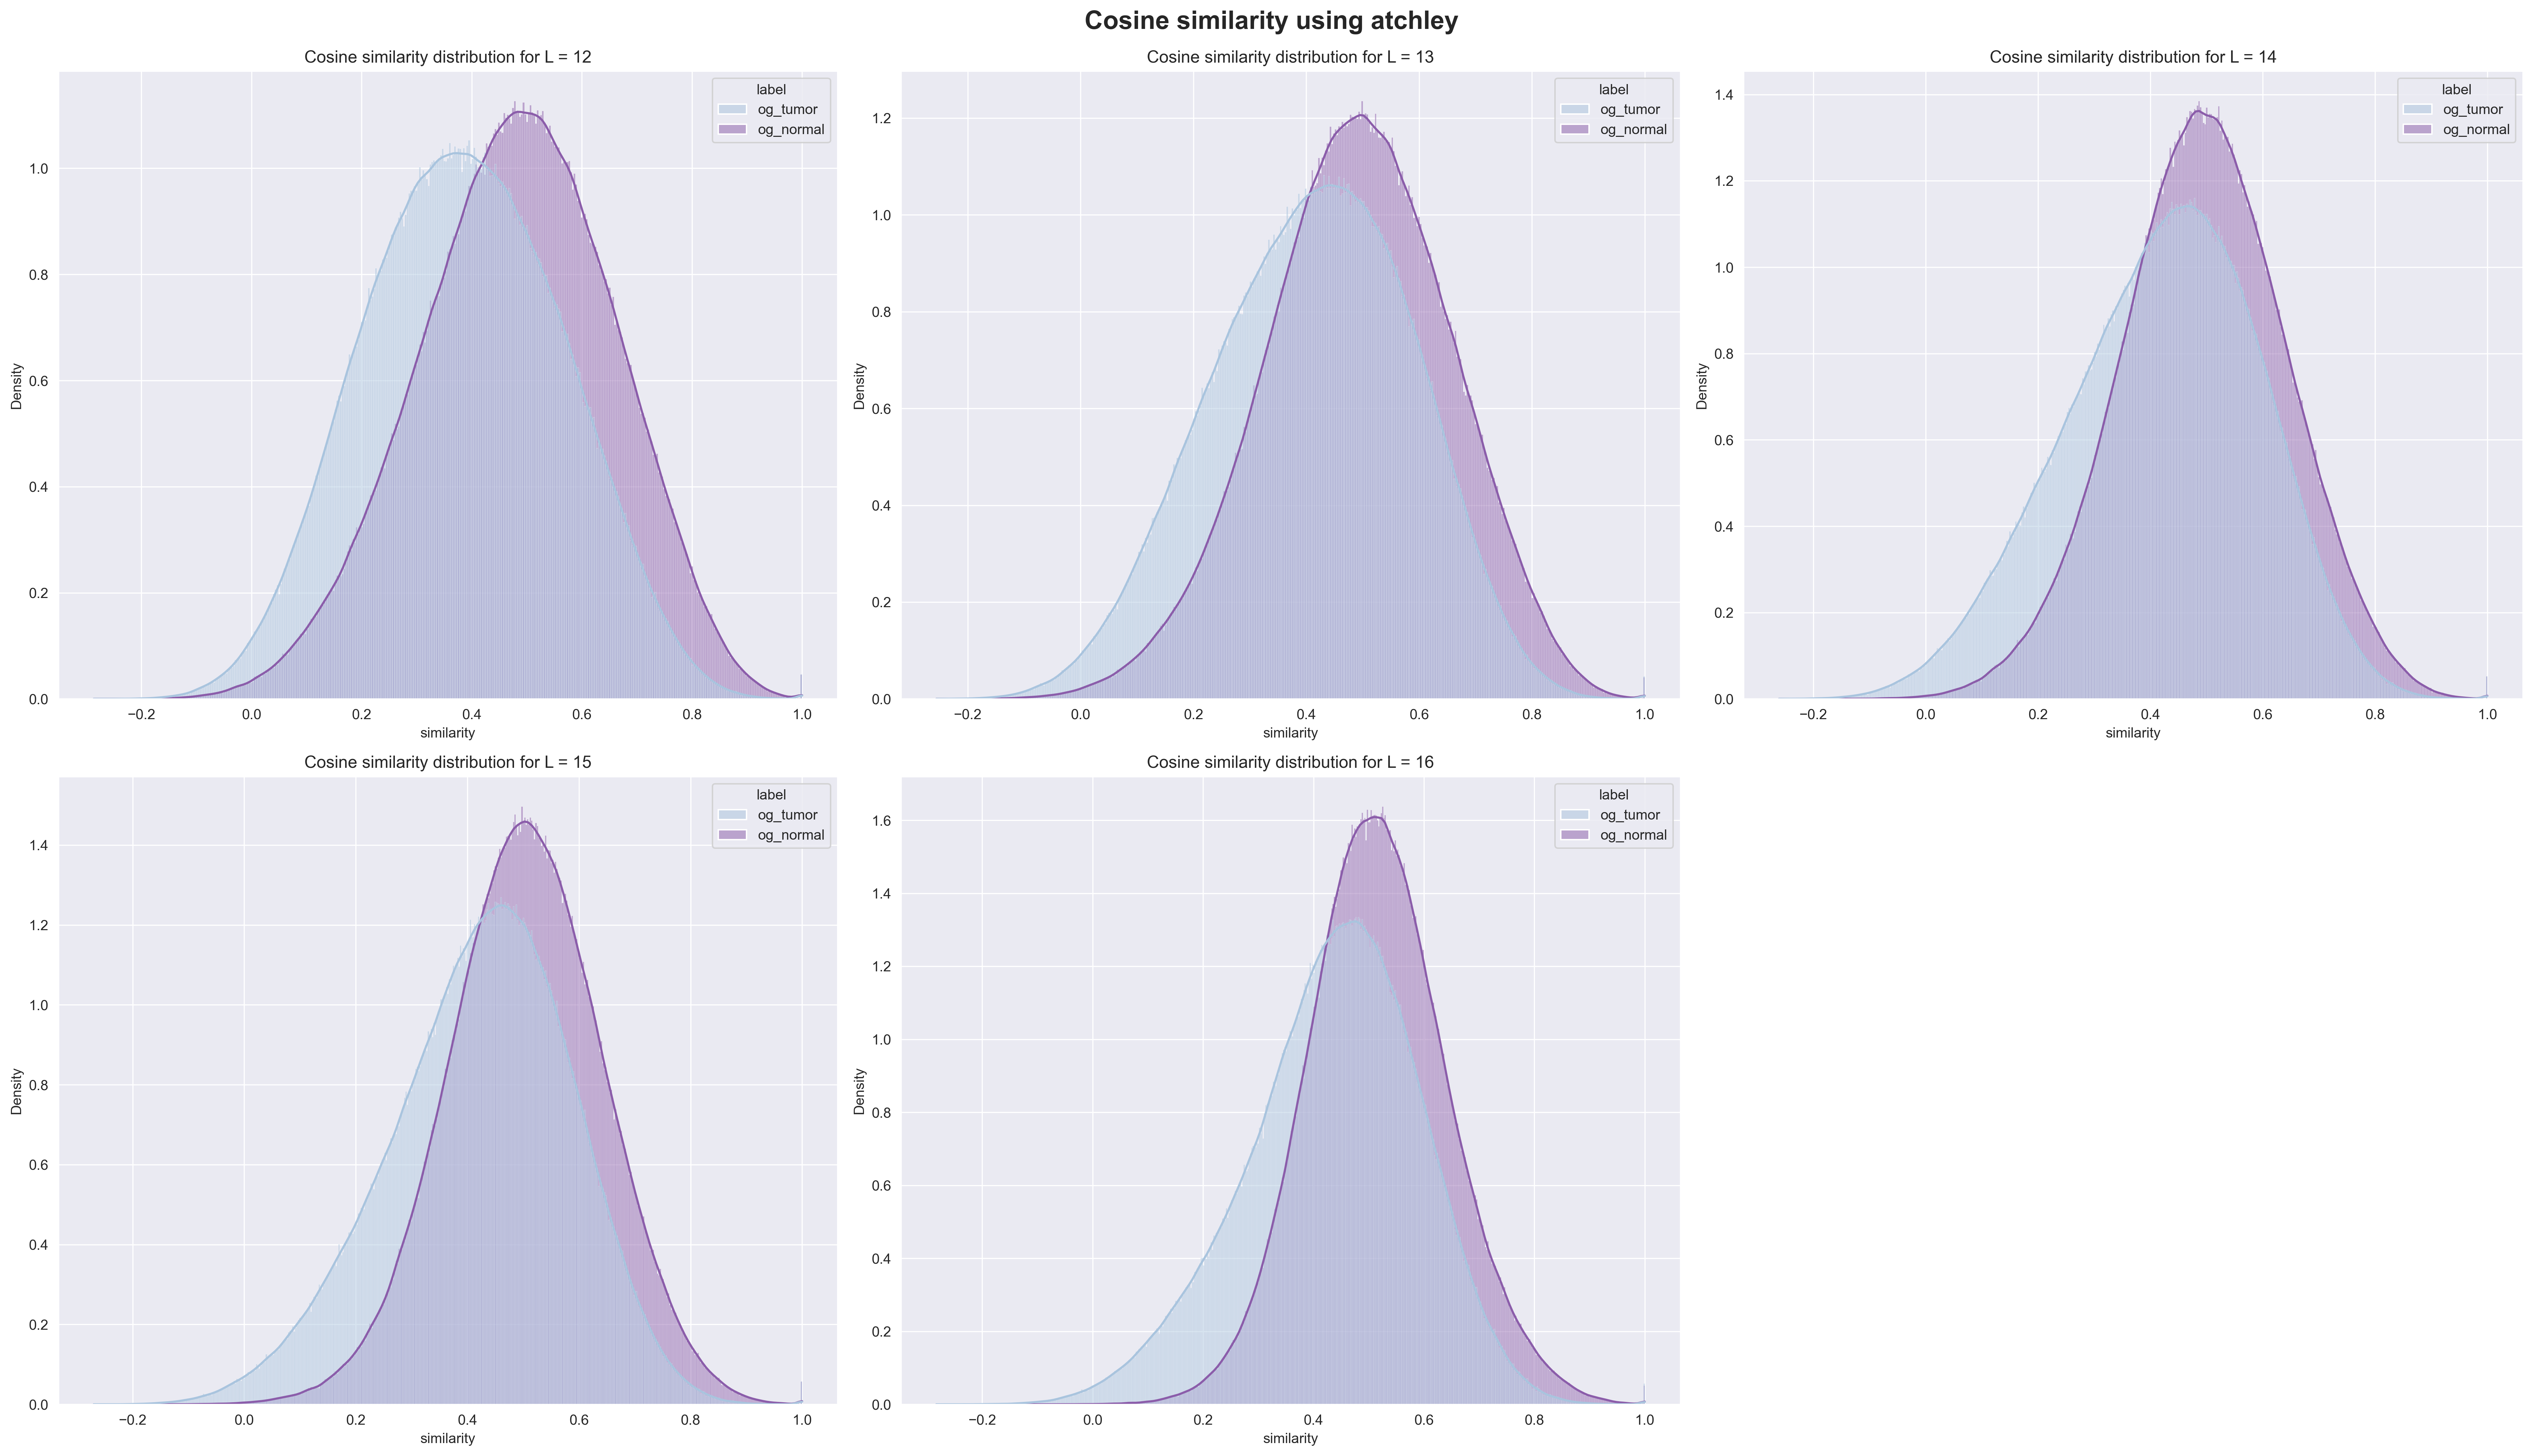

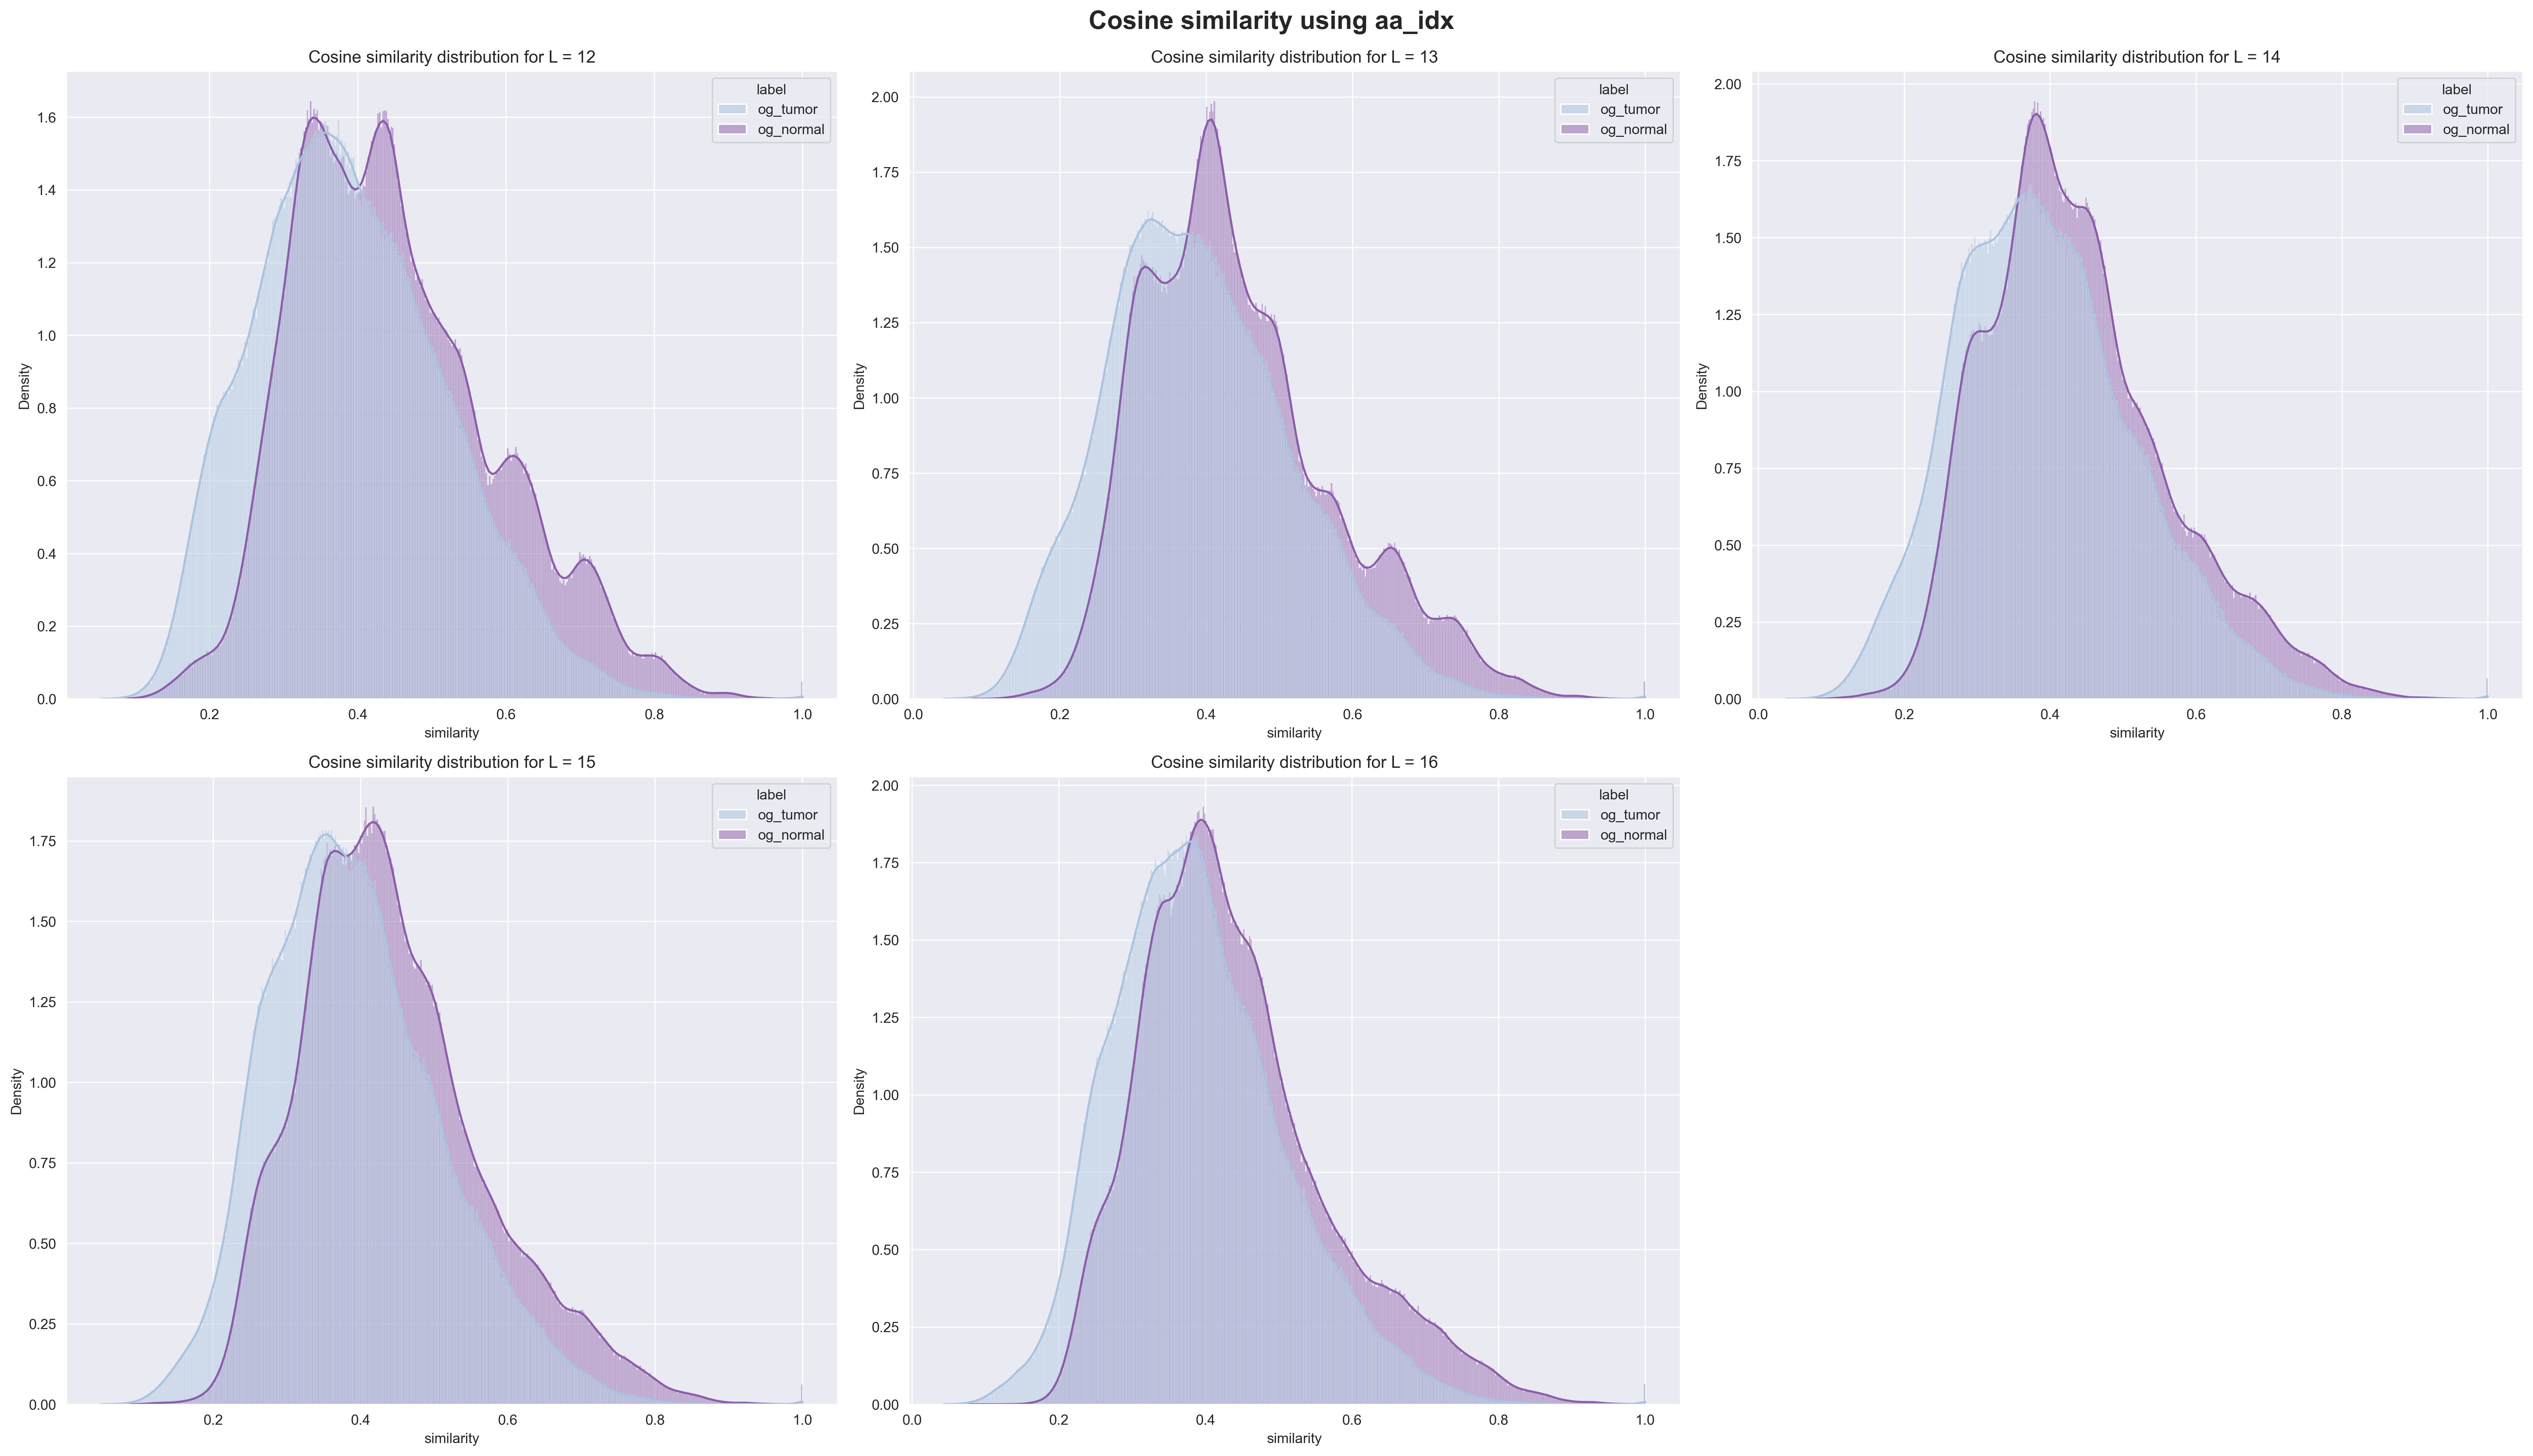

In [18]:
sns.set_palette('BuPu',n_colors=2)
atchley_sim = get_cos(total, 'atchley','og_tumor', "og_normal")#,'mcc', "naive")
plot_cos_dist(atchley_sim, 'atchley')#, 'og_tumor','mcc')

aaidx_sim = get_cos(total, 'aa_idx', 'og_tumor', "og_normal")#, 'mcc', "naive")
plot_cos_dist(aaidx_sim,'aa_idx')

#### Model filters ???

In [ ]:
x = load_models('../output/training_output/benchmark/',
                arch='deepcat', eval_=False)

In [ ]:
model_info('../output/training_output/richie_minmax_redo_withnograd/', arch='richie')

In [ ]:
sns.set_palette('coolwarm')
i = 0
for a in x[12].conv2.weight:
    j=0
    for b in a : 
        #print(b.shape)
        sns.heatmap(b.detach().numpy(), cmap='coolwarm', center=0)
        plt.savefig('./filters/deepconv2_filter_'+str(i)+'_'+str(j)+'.jpg')
        j+=1
        plt.close()
    i+=1

In [ ]:
sns.set_palette('coolwarm')
i=0
for z in x[12].conv1.weight:
    xd = z.squeeze(0).detach().numpy()
    sns.heatmap(xd, cmap='coolwarm', center=0)
    plt.savefig('./filters/deepcat_conv1_filter_'+str(i)+'.jpg')
    i+=1
    plt.close()